# Neural Network Classifier & Regressor

In this tutorial we show how the `NeuralNetworkClassifier` and `NeuralNetworkRegressor` are used.
Both take as an input a (Quantum) `NeuralNetwork` and leverage it in a specific context.
In both cases we also provide a pre-configured variant for convenience, the Variational Quantum Classifier (`VQC`) and Variational Quantum Regressor (`VQR`). The tutorial is structured as follows:


1. [Classification](#Classification) 
    * Classification with an `EstimatorQNN`
    * Classification with a `SamplerQNN`
    * Variational Quantum Classifier (`VQC`)
    

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import an, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

algorithm_globals.random_seed = 42

## Classification

We prepare a simple classification dataset to illustrate the following algorithms.

In [2]:
num_inputs = 2
num_samples = 20

X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1  # El vector X se define entre -1 y 1

In [3]:
X

array([[ 0.5479121 , -0.12224312],
       [ 0.71719584,  0.39473606],
       [-0.8116453 ,  0.9512447 ],
       [ 0.5222794 ,  0.57212861],
       [-0.74377273, -0.09922812],
       [-0.25840395,  0.85352998],
       [ 0.28773024,  0.64552323],
       [-0.1131716 , -0.54552256],
       [ 0.10916957, -0.87236549],
       [ 0.65526234,  0.2633288 ],
       [ 0.51617548, -0.29094806],
       [ 0.94139605,  0.78624224],
       [ 0.55676699, -0.61072258],
       [-0.06655799, -0.91239247],
       [-0.69142102,  0.36609791],
       [ 0.48952431,  0.93501946],
       [-0.34834928, -0.25908059],
       [-0.06088838, -0.62105728],
       [-0.74015699, -0.04859015],
       [-0.5461813 ,  0.33962799]])

In [4]:
print('X.max =', X.max(),'  X.min=',X.min())

X.max = 0.9512447032735118   X.min= -0.9123924684255424


In [5]:
print(np.sum(X, axis=1))

[ 0.42566898  1.1119319   0.1395994   1.09440801 -0.84300086  0.59512603
  0.93325347 -0.65869416 -0.76319591  0.91859114  0.22522742  1.72763829
 -0.05395559 -0.97895046 -0.32532311  1.42454378 -0.60742987 -0.68194566
 -0.78874714 -0.20655331]


In [6]:
print(np.sum(X, axis=1) >= 0)

[ True  True  True  True False  True  True False False  True  True  True
 False False False  True False False False False]


In [8]:
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}

In [9]:
y01

array([1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0])

In [10]:
y = 2 * y01 - 1  # in {-1, +1}

In [11]:
y

array([ 1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1, -1, -1, -1,  1, -1,
       -1, -1, -1])

In [12]:
y_one_hot = np.zeros((num_samples, 2))

In [14]:
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

In [15]:
y_one_hot

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [16]:
list(zip(X, y))

[(array([ 0.5479121 , -0.12224312]), 1),
 (array([0.71719584, 0.39473606]), 1),
 (array([-0.8116453,  0.9512447]), 1),
 (array([0.5222794 , 0.57212861]), 1),
 (array([-0.74377273, -0.09922812]), -1),
 (array([-0.25840395,  0.85352998]), 1),
 (array([0.28773024, 0.64552323]), 1),
 (array([-0.1131716 , -0.54552256]), -1),
 (array([ 0.10916957, -0.87236549]), -1),
 (array([0.65526234, 0.2633288 ]), 1),
 (array([ 0.51617548, -0.29094806]), 1),
 (array([0.94139605, 0.78624224]), 1),
 (array([ 0.55676699, -0.61072258]), -1),
 (array([-0.06655799, -0.91239247]), -1),
 (array([-0.69142102,  0.36609791]), -1),
 (array([0.48952431, 0.93501946]), 1),
 (array([-0.34834928, -0.25908059]), -1),
 (array([-0.06088838, -0.62105728]), -1),
 (array([-0.74015699, -0.04859015]), -1),
 (array([-0.5461813 ,  0.33962799]), -1)]

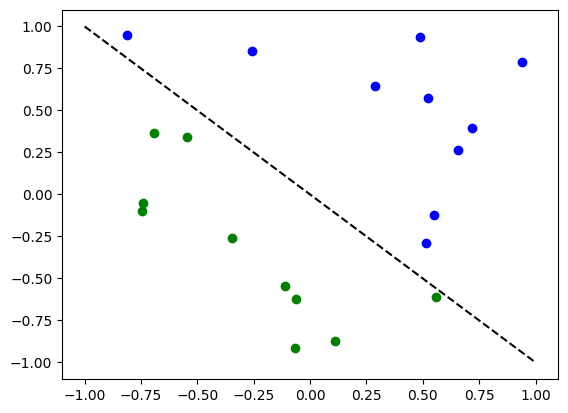

In [17]:
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")

plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

### Classification with an `EstimatorQNN`

First we show how an `EstimatorQNN` can be used for classification within a `NeuralNetworkClassifier`. In this context, the `EstimatorQNN` is expected to return one-dimensional output in $[-1, +1]$. This only works for binary classification and we assign the two classes to $\{-1, +1\}$.

In [18]:
feature_map = ZZFeatureMap(2)
ansatz = RealAmplitudes(2)

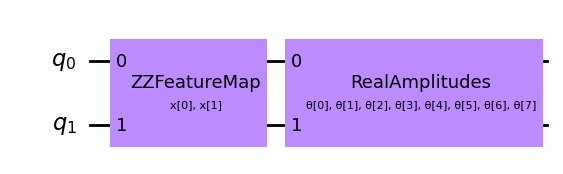

In [19]:
# construct QNN
qc = QuantumCircuit(2)

qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw(output="mpl")

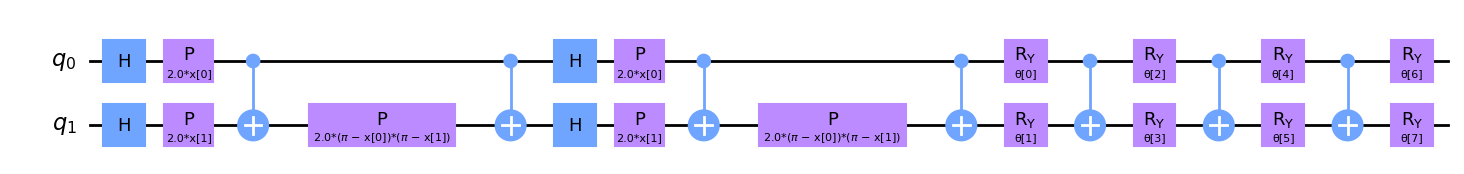

In [20]:
qc.decompose().draw(output="mpl")

Create a quantum neural network

In [21]:
estimator_qnn = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

In [22]:
# QNN maps inputs to [-1, +1]
estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))

array([[0.23521988]])

We will add a callback function called `callback_graph`. This will be called for each iteration of the optimizer and will be passed two parameters: the current weights and the value of the objective function at those weights. For our function, we append the value of the objective function to an array so we can plot iteration versus objective function value and update the graph with each iteration. However, you can do whatever you want with a callback function as long as it gets the two parameters mentioned passed. 

In [23]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [24]:
# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

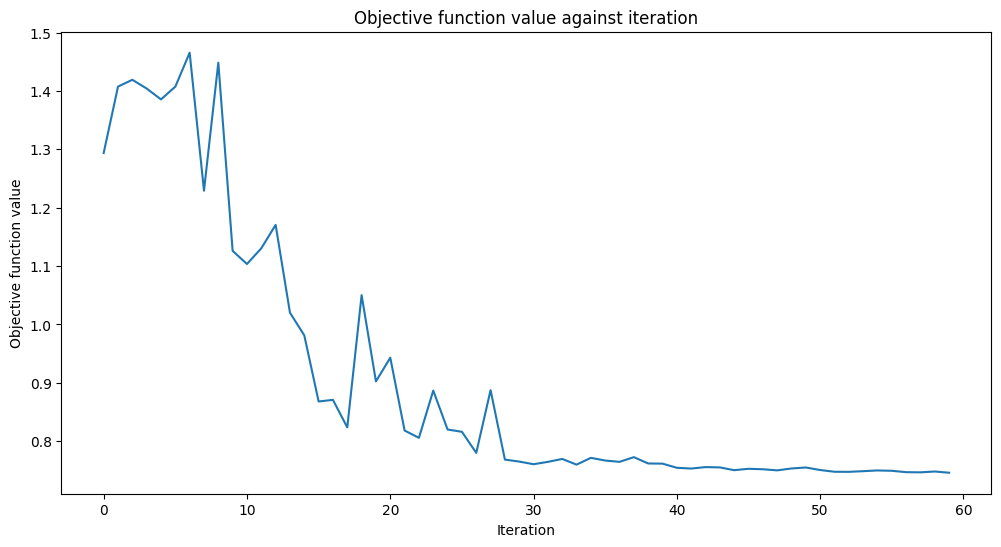

0.8

In [25]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X, y)

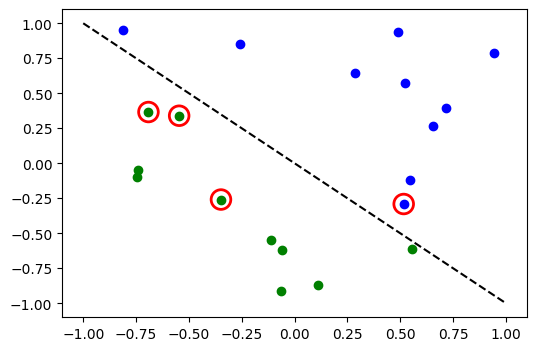

In [26]:
# evaluate data points
y_predict = estimator_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

Now, when the model is trained, we can explore the weights of the neural network. Please note, the number of weights is defined by ansatz.

In [27]:
estimator_classifier.weights

array([ 0.86209107, -1.06526254, -0.10663602, -0.39086371,  1.0894299 ,
        0.59368219,  2.22731471, -1.04769663])

### Classification with a `SamplerQNN`

Next we show how a `SamplerQNN` can be used for classification within a `NeuralNetworkClassifier`. In this context, the `SamplerQNN` is expected to return $d$-dimensional probability vector as output, where $d$ denotes the number of classes. 
The underlying `Sampler` primitive returns quasi-distributions of bit strings and we just need to define a mapping from the measured bitstrings to the different classes. For binary classification we use the parity mapping.

In [28]:
# construct feature map
feature_map = ZZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=1)

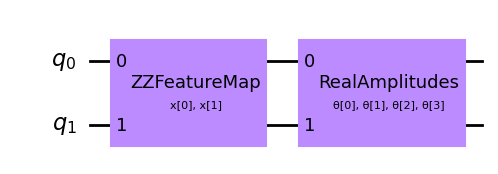

In [29]:
# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

qc.decompose().draw(output="mpl")

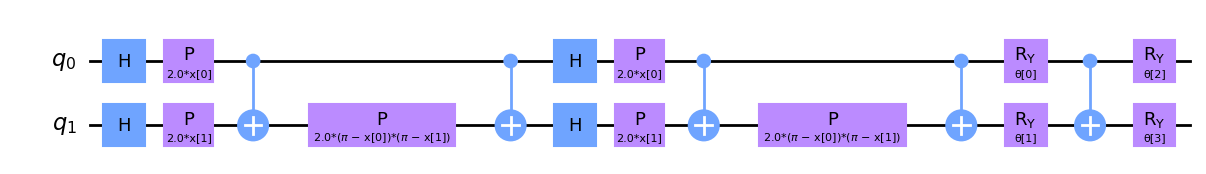

In [30]:
qc.decompose().decompose().draw(output="mpl")

In [31]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2  # https://www.w3schools.com/python/ref_string_format.asp and https://www.programiz.com/python-programming/methods/string/count

output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [32]:
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
)

In [33]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=50), callback=callback_graph
)

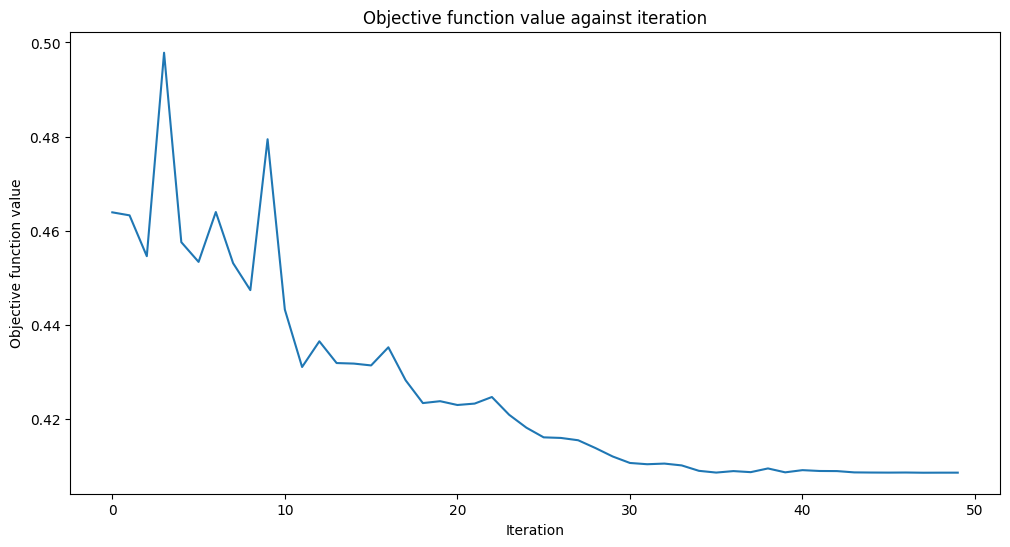

0.75

In [34]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(X, y01)

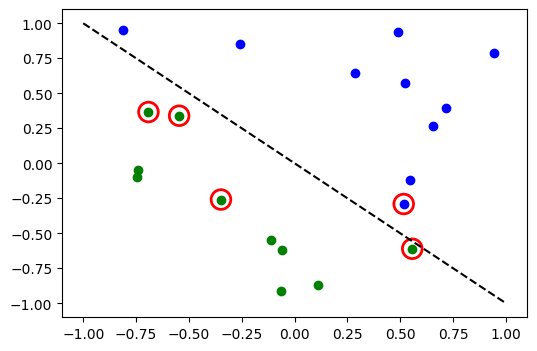

In [35]:
# evaluate data points
y_predict = sampler_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

Again, once the model is trained we can take a look at the weights. As we set `reps=1` explicitly in our ansatz, we can see less parameters than in the previous model.

In [36]:
sampler_classifier.weights

array([ 1.57534656,  0.0433836 , -0.84993621, -1.13887193])

### Variational Quantum Classifier (`VQC`)

The `VQC` is a special variant of the `NeuralNetworkClassifier` with a `SamplerQNN`. It applies a parity mapping (or extensions to multiple classes) to map from the bitstring to the classification, which results in a probability vector, which is interpreted as a one-hot encoded result. By default, it applies this the `CrossEntropyLoss` function that expects labels given in one-hot encoded format and will return predictions in that format too.

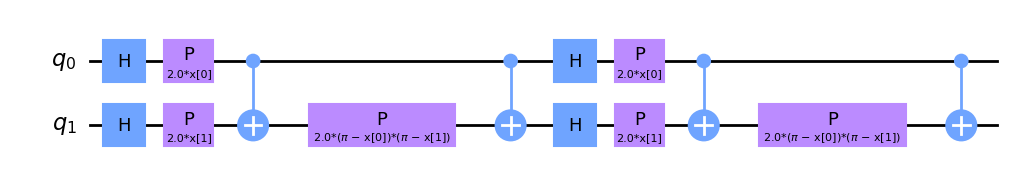

In [37]:
# construct feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(num_inputs)
feature_map.decompose().draw(output="mpl")

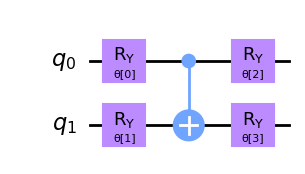

In [38]:
ansatz = RealAmplitudes(num_inputs, reps=1)
ansatz.decompose().draw(output="mpl")

In [39]:
# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
)

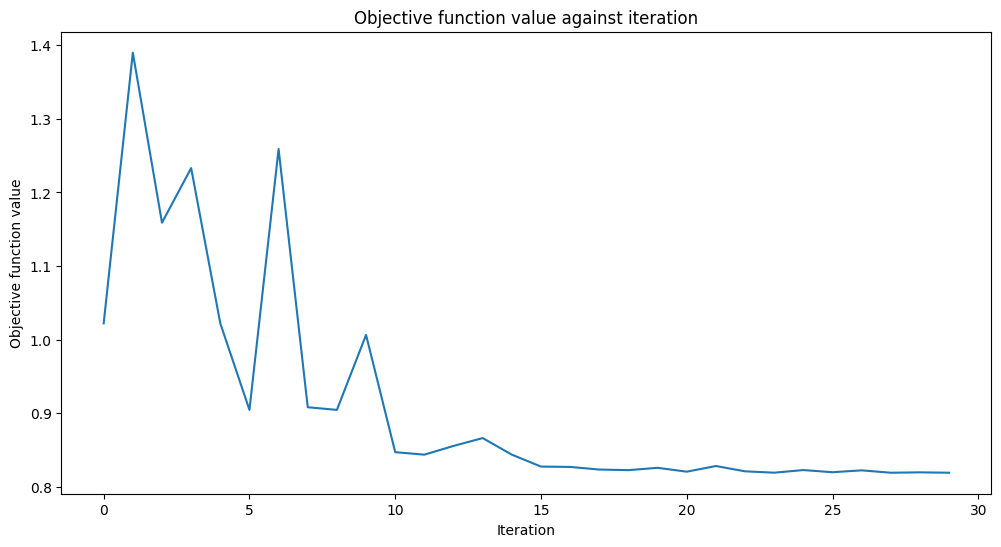

0.75

In [40]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_one_hot)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y_one_hot)

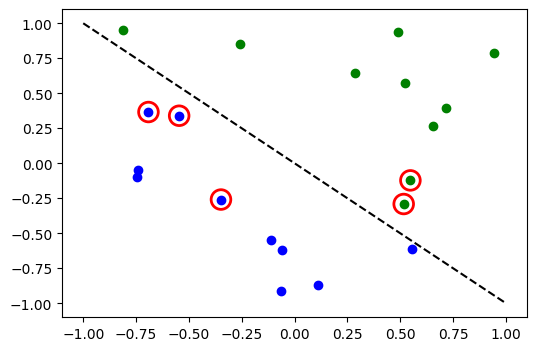

In [41]:
# evaluate data points
y_predict = vqc.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [42]:
vqc.weights

array([ 0.14034913, -0.54881825,  0.55713862,  0.924383  ])

### Multiple classes with VQC
In this section we generate an artificial dataset that contains samples of three classes and show how to train a model to classify this dataset. This example shows how to tackle more interesting problems in machine learning. Of course, for a sake of short training time we prepare a tiny dataset. We employ `make_classification` from SciKit-Learn to generate a dataset. There 10 samples in the dataset, 2 features, that means we can still have a nice plot of the dataset, as well as no redundant features, these are features are generated as a combinations of the other features. Also, we have 3 different classes in the dataset, each classes one kind of centroid and we set class separation to `2.0`, a slight increase from the default value of `1.0` to ease the classification problem.

Once the dataset is generated we scale the features into the range `[0, 1]`.

In [43]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

X, y = make_classification(
    n_samples=10,
    n_features=2,
    n_classes=3,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=algorithm_globals.random_seed,
)
X = MinMaxScaler().fit_transform(X)

Let's see how our dataset looks like.

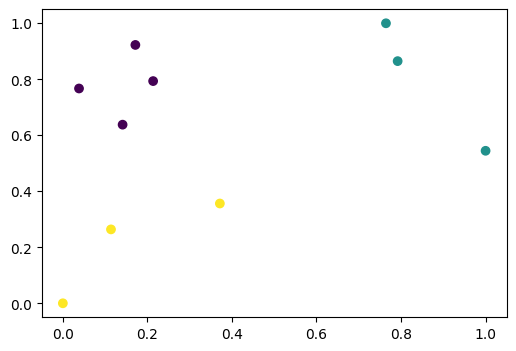

In [44]:
plt.scatter(X[:, 0], X[:, 1], c=y)

We also transform labels and make them categorical.

In [45]:
y_cat = np.empty(y.shape, dtype=str)
y_cat[y == 0] = "A"
y_cat[y == 1] = "B"
y_cat[y == 2] = "C"
print(y_cat)

['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


We create an instance of `VQC` similar to the previous example, but in this case we pass a minimal set of parameters. Instead of feature map and ansatz we pass just the number of qubits that is equal to the number of features in the dataset, an optimizer with a low number of iteration to reduce training time, a quantum instance, and a callback to observe progress.

In [46]:
vqc = VQC(
    num_qubits=2,
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
)

Start the training process in the same way as in previous examples.

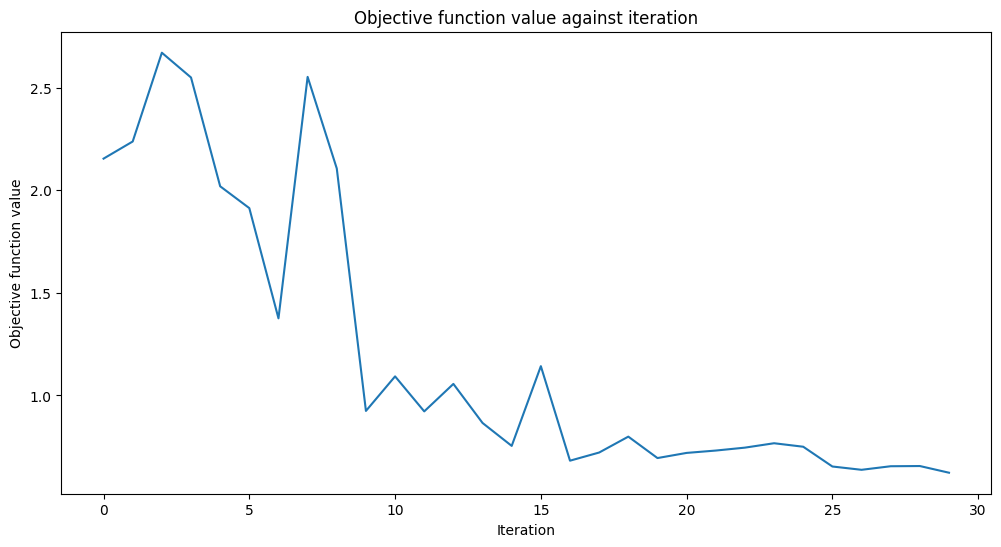

0.9

In [47]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_cat)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y_cat)

Despite we had the low number of iterations, we achieved quite a good score. Let see the output of the `predict` method and compare the output with the ground truth.

In [48]:
predict = vqc.predict(X)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_cat}")

Predicted labels: ['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'B']
Ground truth:     ['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


In [49]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright